In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation
## Due Date: Thursday, November 30th, 11:59 PM PDT
You must submit this assignment to Gradescope by the on-time deadline, Thursday, November 30th, 11:59 PM. 
Please read the syllabus for the grace period policy. 
No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). 
**We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** 
This way, you will have ample time to reach out to staff for submission support.

### Collaboration Policy

Data science is a collaborative activity. 
While you may talk with others about this project, we ask that you **write your solutions individually**. 
If you discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

In [3]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
#imports

import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

In [5]:
#import data

import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [6]:
#read in training and test data
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

1000


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [7]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [8]:
#creating a train-validation split

# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

In [9]:
from projB2_utils import words_in_texts

#importing words_in_texts
#inputs: list of words, series of text
#output: 2D array, 1 if wor in the text, 0 if the word isn't

#example
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [12]:
# import libraries
# you may use any of these to create your features
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import GridSearchCV
import re
from collections import Counter

In [13]:
original_training_data[['email', 'spam']].iloc[11]

email    there's been well documented articles, studies...
spam                                                     0
Name: 11, dtype: object

In [14]:
#function that checks if the number of characters in a text is > 3000
#input: series
#output: series of 0's and 1's [1 if > 3000, 0 if <=]

def number_of_characters(series):
    num_char = (series.str.len() > 3000).astype('int')
    return num_char.values

number_of_characters(train['email'])

array([0, 1, 0, ..., 0, 0, 0])

In [15]:
#function that checks if the number of exclamation marks in a text is > 2.5
#input: series
#output: series of 0's and 1's [1 if > 2.5, 0 if <=]

def number_of_exclamations(series):
    exc_series = [len(re.findall('!', email)) for email in series] 
    num_exc_series = pd.Series(exc_series)
    num_exc = (num_exc_series > 2.5).astype('int')
    return num_exc

number_of_exclamations(train['email'])

0       0
1       0
2       1
3       0
4       1
       ..
7508    0
7509    1
7510    1
7511    0
7512    0
Length: 7513, dtype: int64

In [16]:
#function that checks if the number of html tags in a text is > 20
#input: series
#output: series of 0's and 1's [1 if > 20, 0 if <=]

def num_html_tags(series):
    html_series = [len(re.findall('<.*>', email)) for email in series] 
    num_html_series = pd.Series(html_series)
    num_html = (num_html_series > 20).astype('int')
    return num_html

In [46]:
# list of words chosen for likely being in spam emails, with frequency of these words being used for prediction
some_words = ['html', 'body', 'please', 'click', 'font', 'head', 'cash',  'debt', 'prize', 'million', 'meta', '\n', 'money', 'business', 'offer', 'deal', 'url', 'membership', 'lifetime', '100%']

#create predictive arrays describing each feature selected for the model 
x_words = words_in_texts(some_words, train['email'])
x_char = number_of_characters(train['email'])
x_exc = number_of_exclamations(train['email'])
x_html = num_html_tags(train['email'])
X_int = [np.append(x_words[i], x_char[i]) for i in range(len(x_words))]
X_int2 = [np.append(X_int[i], x_html[i]) for i in range(len(x_words))]
X_train = [np.append(X_int2[i], x_exc[i]) for i in range(len(x_words))]
print(x_words[0:10], X_train[:10])
Y_train = np.array(train['spam'])
print(Y_train[:10])

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]] [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1]), array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0]), array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [18]:
#create logistic regression model and fit the model to the encoded matrix

lr = LogisticRegression()
lr.fit(X_train, Y_train)
train_accuracy = lr.score(X_train, Y_train)
print(train_accuracy)

0.8771462797817117


In [19]:
#ft the 

lmodel = LogisticRegression()
lmodel.fit(X_int, Y_train)
lmodel_accuracy = lmodel.score(X_int, Y_train)
print(lmodel_accuracy)

0.8710235591641156


In [19]:
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'saga']}
grid = GridSearchCV(estimator=lr, param_grid=parameters)
grid_result = grid.fit(X_train, Y_train)
grid_result.cv_results_['mean_test_score']

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.87554859, 0.87554859, 0.87554859, 0.87554859])

<!-- BEGIN QUESTION -->

<br>

---

## Question 1

In the following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?


1. I used exploratory data analysis to analyze or look for notable differences in different characteristics between the spam and the ham emails to determine which features should be used to construct my model and which features would be better to not use. This was done through visualizations (mainly bar plots comparing the number/proportion/etc. of a specific characteristic between spam and ham emails) and by manipulating the training data to explore for those features. 
2. Some variables that I tried that seem to work are looking for html tags in the email, looking at the number of characters in the email, the number of commas in the email, if the email was a reply vs. not a reply, and more. Some variables that I tried that didn't seem to work as well were whether the email was forwards vs. not forwards, and the number of words in the subject. Specifically looking at the number of words in the subject, I found almost no difference in the number of words in the subject between the spam and ham emails, which would make it very not a good metric to base my model off of.
3. One thing that surprised me was that testing words was actually extremely effective when increasing the training and test accuracy. I figured that words such as body, head, click, guaranteed, and other spam email content related words would help increase the accuracy because they do show up more in spam emails then you would expect with normal emails, however the fact that adding one or two words could increae the accuracy by a percent or two was really surprising to me

I attempted to show the pairwise comparison between the words I choose as potential features to see which words are correlated with one another. This is helpful when constructing my model because it can elucidate words that are correlated with one another (tend to show up in the same emails). As I use other graphs to see which words tend to be more in spam emails, if I see a word is more common in spam emails, then it might also be likely that the word highly correlated with that word would also show up more in spam emails, and would therefore then be a good word to train my model with. Looking at the plot, we can see some words that are highly correlated with each other. Some examples from this word list that seem to be positively correlated would be font and body, 100% and font, head and meta, etc. 

<Axes: >

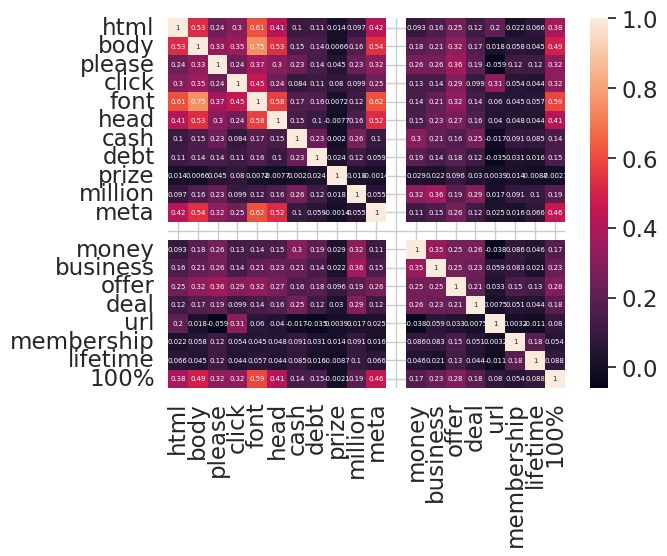

In [84]:
#visualize pariwise comparison between words chosen as features to see if correlation between word frequency

word_count_df = pd.DataFrame(words_in_texts(some_words, train['email']))
word_count_df.columns = some_words
sns.heatmap(word_count_df.corr(), annot = True, annot_kws = {'size' : 5}, xticklabels = True, yticklabels = True)

In [85]:
#create ROC curve, showing trade-off for each possible cutoff probability

def tpr_threshold(X, Y, T): # Same as recall
    Y_hat = predict_threshold(lr, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(lr, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

Text(0.5, 1.0, 'ROC Curve')

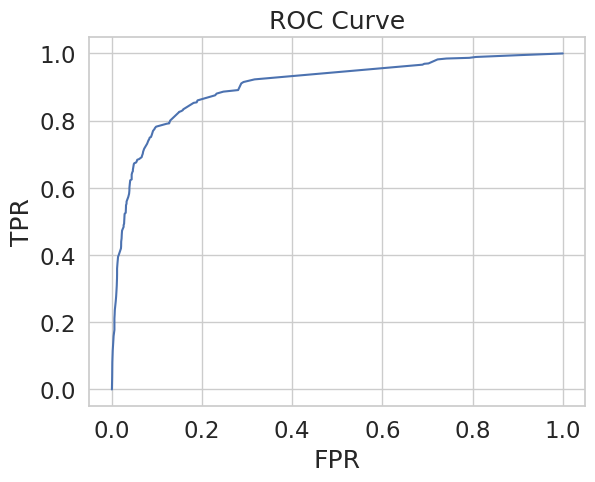

In [88]:
thresholds = np.linspace(0, 1, 100)

tprs = [tpr_threshold(X_train, Y_train, t) for t in thresholds]
fprs = [fpr_threshold(X_train, Y_train, t) for t in thresholds]

plt.plot(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve')

In [89]:
#calculate accuracy one more time for training set
train_predictions = lr.predict(X_train)
test_predictions = lr.predict(X_test)

# print your training accuracy 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.8771462797817117

In [93]:
#make our X-test which is the all the val columns except for the spam/ham column
#put that through all of the same things I did with the train set

#calculate accuracy for test set
X_test_before = test[['id', 'subject', 'email']]
X_test_html = num_html_tags(X_test_before['email'])
X_test_exc = number_of_exclamations(X_test_before['email'])        
X_test_char = number_of_characters(X_test_before['email'])
X_test_words = words_in_texts(some_words, X_test_before['email'])
X_test_int = [np.append(X_test_words[i], X_test_char[i]) for i in range(len(X_test_before))]
X_test_int2 = [np.append(X_test_int[i], X_test_exc[i]) for i in range(len(X_test_before))]
X_test = [np.append(X_test_int2[i], X_test_html[i]) for i in range(len(X_test_before))]


The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 3 times per day, so please use your submissions wisely!

In [95]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20231130_182130.csv.


You may now upload this CSV file to Gradescope for scoring.
